# Imports and functions
this will probably eventually become the environment which I will solidate into a conda / pip file

In [2]:
import torch
from torch_geometric.loader import DataLoader
import numpy as np
import pandas as pd
from scipy.io import mmread
import matplotlib.pyplot as plt
import anndata as ad
import h5py
import scanpy as sc
import re
import os
import os.path as osp
import sys
from matplotlib_venn import venn2, venn3
from random import sample
from sklearn.preprocessing import MinMaxScaler
import networkx as nx
from torch_geometric.data import Data
from torch_geometric.utils import add_remaining_self_loops, to_undirected
from tqdm import tqdm

# borrowed from stackoverflow (https://stackoverflow.com/questions/61133916/is-there-in-python-a-single-function-that-shows-the-full-structure-of-a-hdf5-fi)
def h5_tree(val, pre=''):
    items = len(val)
    for key, val in val.items():
        items -= 1
        if items == 0:
            # the last item
            if type(val) == h5py._hl.group.Group:
                print(pre + '└── ' + key)
                h5_tree(val, pre+'    ')
            else:
                try:
                    print(pre + '└── ' + key + ' (%d)' % len(val))
                except TypeError:
                    print(pre + '└── ' + key + ' (scalar)')
        else:
            if type(val) == h5py._hl.group.Group:
                print(pre + '├── ' + key)
                h5_tree(val, pre+'│   ')
            else:
                try:
                    print(pre + '├── ' + key + ' (%d)' % len(val))
                except TypeError:
                    print(pre + '├── ' + key + ' (scalar)')

def output_divider():
    print('----------------------------------------')

# 3/16
### key items
- prior to this, I have verified that I can install PDGrapher on colab and run single_fold.py, multiple_folds.py can't be completed due to memory constraints 
- inspected how data is processed from GCTx to h5ad to npx to pt and then fed into the model for training 
- familiarizing with a few pytorch functions and datatypes


In [2]:
genetic_a549_1f = torch.load('example_data/processed/torch_data/chemical/real_lognorm/data_backward_A549.pt')
# inspect
print(genetic_a549_1f[:1])
print(genetic_a549_1f[0].num_nodes)
dataloader_genetic_a549_1f = DataLoader(genetic_a549_1f, batch_size=64)
# print(genetic_a549_1f['train_index_backward'])
# print(genetic_a549_1f['test_index_backward'])
# print(genetic_a549_1f['train_index_forward'])
# print(genetic_a549_1f['test_index_forward'])

FileNotFoundError: [Errno 2] No such file or directory: 'example_data/processed/torch_data/chemical/real_lognorm/data_backward_A549.pt'

In [ ]:
# query just one data instance in the variable
te = next(iter(dataloader_genetic_a549_1f))  
print(te)
print(te[0])
print("#####################")
print("perturbagen: ", te[0].perturbagen_name)
print("diseased: ", te[0].diseased, te[0].diseased.shape)
print("intervention:", te[0].intervention, te[0].intervention.shape)
print("treated: ", te[0].treated, te[0].treated.shape)
print( len(te[0].gene_symbols), "gene_symbols: ", te[0].gene_symbols)
print("mutations: ", te[0].mutations, te[0].mutations.shape)
print("num_nodes: ", te[0].num_nodes)
print("batch: ", te[0].batch)
print("#####################")
# inspeact data structure
intervention_0_np = te[0].intervention.detach().numpy()
print(intervention_0_np)
print(intervention_0_np.shape)
# retrieves intervention target
np.where(intervention_0_np == 1)
print(intervention_0_np[129])
print(te[0].gene_symbols[129])
# retrieves mutations
np.where(te[0].mutations.detach().numpy() == 1)
indices = [1543, 2064, 2875]
print([te[0].gene_symbols[i] for i in indices])

DataBatch(perturbagen_name=[64], diseased=[685824], intervention=[685824], treated=[685824], gene_symbols=[64], mutations=[685824], num_nodes=685824, batch=[685824], ptr=[65])
Data(perturbagen_name='neratinib', diseased=[10716], intervention=[10716], treated=[10716], gene_symbols=[10716], mutations=[10716], num_nodes=10716)
#####################
perturbagen:  neratinib
diseased:  tensor([0.5129, 0.6348, 0.4011,  ..., 0.4595, 0.3964, 0.4270]) torch.Size([10716])
intervention: tensor([0., 0., 0.,  ..., 0., 0., 0.]) torch.Size([10716])
treated:  tensor([0.4478, 0.8018, 0.6512,  ..., 0.3526, 0.4006, 0.3669]) torch.Size([10716])
10716 gene_symbols:  ['FLNC', 'MAP2K4', 'SGCD', 'SGCG', 'MYOZ1', 'KCND2', 'INPPL1', 'ENO1', 'FBXW11', 'SIAH2', 'AGR2', 'ANK3', 'DYSF', 'UBE2I', 'PIK3R1', 'ADRA1A', 'GRB2', 'HIPK3', 'ABL1', 'MLH1', 'WNK1', 'PCBP2', 'AKT1', 'PLCG1', 'NCK1', 'FYN', 'CAMKK2', 'MYOZ3', 'CRK', 'SMURF2', 'WIPI2', 'AKT2', 'OTUD4', 'USP53', 'CAPN3', 'ADRA1B', 'MYOZ2', 'ADRA1D', 'TNFAIP8', 'F

In general, .pt file is read in using torch.load, and turned into a dataloader object using torch_geometric.dataloader. To query the data in it, we iter with either iter function or direct loop over its constituents. Each data instance will have a batch size that we specify at the loading step. Each individual datapoint has a series of high dimensional vectors associated with it (dimension is the number of genes), the expression of the diseased cell, a one-hot encoding of the drug/perturbatino used, the expression of the treated cell, the gene names, and one-hot encoding of mutations.

To get to a .pt file, see scripts in data/scripts/rep-learning-approach, which takes in npz files and process them to pytorch data files. To get to the npz file, use the process_data files under data/scripts/lincs, which takes in original downloaded data and returns npz files. 

# 3/17
key items
- inspecting the data download decision from LINCS for the original work (to understand what I need to do)
- downloaded dixit data and part of joung data to local (I'm guessing I only need the smaller, processed files of joung)
- understood data processing pipeline for pdgrapher

In [ ]:
# loading in dixit's data for fun
dixit_raw_tfs_highmoi = mmread('/Users/hli/Desktop/Harvard/Classes/sp25/BMI 702/project/work/dixit_data/GSE90063_RAW/GSM2396860_k562_tfs_highmoi.mtx.txt')
dixit_raw_tfs_highmoi_genes = pd.read_csv("/Users/hli/Desktop/Harvard/Classes/sp25/BMI 702/project/work/dixit_data/GSE90063_RAW/GSM2396860_k562_tfs_highmoi_genenames.csv")
dixit_raw_tfs_highmoi_cells = pd.read_csv("/Users/hli/Desktop/Harvard/Classes/sp25/BMI 702/project/work/dixit_data/GSE90063_RAW/GSM2396860_k562_tfs_highmoi_cellnames.csv")
dixit_raw_tfs_highmoi_anndata = anndata.AnnData(X=dixit_raw_tfs_highmoi, 
                                                obs=pd.DataFrame(index=dixit_raw_tfs_highmoi_genes), 
                                                var=pd.DataFrame(index=dixit_raw_tfs_highmoi_cells)).T

In [ ]:
print(f"Non-zero entries: {dixit_raw_tfs_highmoi.nnz}")
print(f"Max value: {dixit_raw_tfs_highmoi.max()}")
print(f"Min value: {dixit_raw_tfs_highmoi.min()}")


Non-zero entries: 154803161
Max value: 5633.0
Min value: 0.0


(23529, 51898)


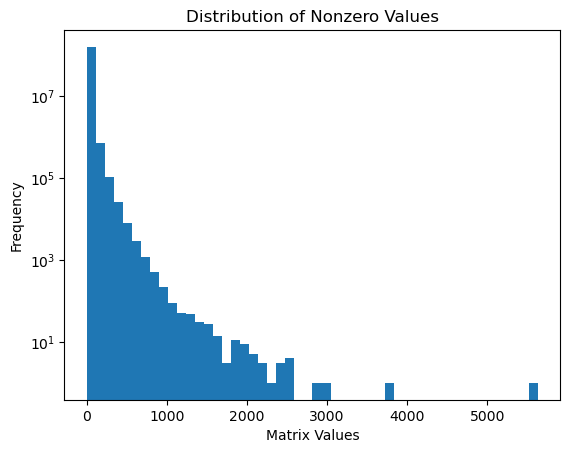

In [19]:
print(dixit_raw_tfs_highmoi.shape)

plt.hist(dixit_raw_tfs_highmoi.data, bins=50, log=True)
plt.xlabel("Matrix Values")
plt.ylabel("Frequency")
plt.title("Distribution of Nonzero Values")
plt.show()

In [41]:
print(dixit_raw_tfs_highmoi_anndata.obs_names[:10])
print(dixit_raw_tfs_highmoi_anndata.var_names[:10])
dixit_raw_tfs_highmoi_anndata

NameError: name 'dixit_raw_tfs_highmoi_anndata' is not defined

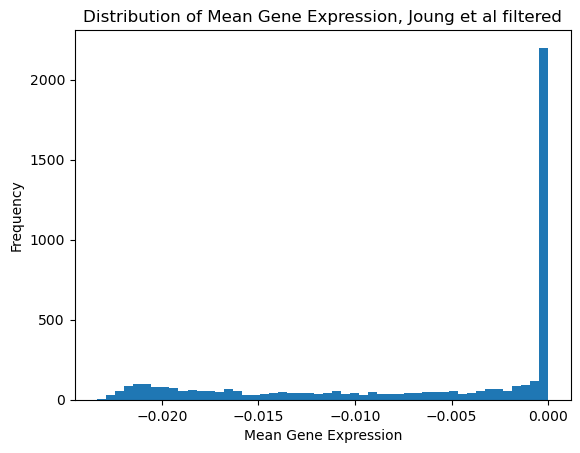

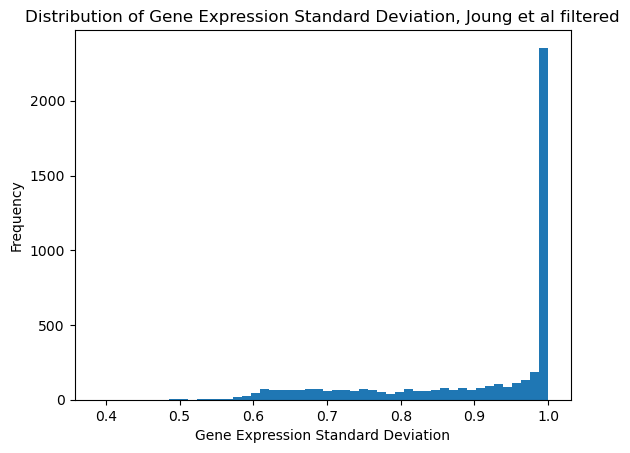

#############################################


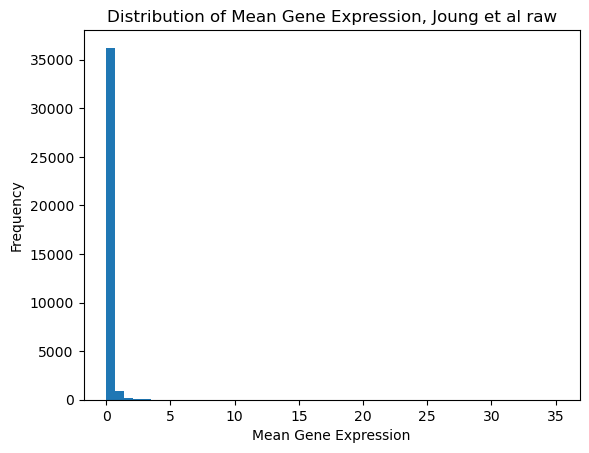

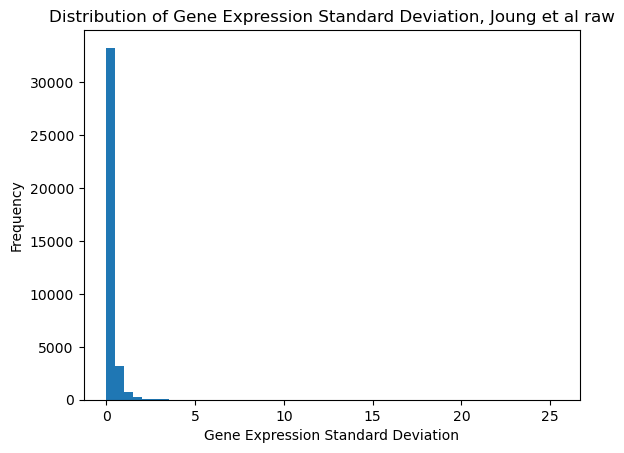

In [62]:
gene_means_filt = []
gene_stds_filt = []
for gene in joung_diff_filt_df.columns:
    gene_means_filt.append(joung_diff_filt_df[gene].mean())
    gene_stds_filt.append(joung_diff_filt_df[gene].std())

plt.hist(gene_means_filt, bins=50)
plt.xlabel("Mean Gene Expression")
plt.ylabel("Frequency")
plt.title("Distribution of Mean Gene Expression, Joung et al filtered")
plt.show()

plt.hist(gene_stds_filt, bins=50)
plt.xlabel("Gene Expression Standard Deviation")
plt.ylabel("Frequency")
plt.title("Distribution of Gene Expression Standard Deviation, Joung et al filtered")
plt.show()

print("#############################################")
gene_means_raw = []
gene_stds_raw = []
for gene in joung_diff_raw_df.columns:
    gene_means_raw.append(joung_diff_raw_df[gene].mean())
    gene_stds_raw.append(joung_diff_raw_df[gene].std())

plt.hist(gene_means_raw, bins=50)
plt.xlabel("Mean Gene Expression")
plt.ylabel("Frequency")
plt.title("Distribution of Mean Gene Expression, Joung et al raw")
plt.show()

plt.hist(gene_stds_raw, bins=50)
plt.xlabel("Gene Expression Standard Deviation")
plt.ylabel("Frequency")
plt.title("Distribution of Gene Expression Standard Deviation, Joung et al raw")
plt.show()



Within process_data.py, gctx is first passed into loads_data() as an h5py object, this function does nothing but extract relevant row and column names to save the h5py as a pd dataframe, note both perturbed and control are passed. 

Next, the df goes through filter_data_metadata() which keeps only the cell id's that are also found in the instinfo_beta.txt file. 

Next, the df goes through filter_cell_lines_custom() which keeps only the cell lines that they define. 

Next, the df goes through filter_samples_with_unknown_perturbed_genes() (did they forget to take this step out according to their comments...?) which checks if the perturbed gene in each cell is found in geneinfo_beta.txt file. 

Finally, the df is passed through normalize_and_save() to get divided into cell lines and each saved as an npz file. 

# 3/19
key items
- begin constructing my data for test run on pdgrapher
- ok, at the point where the original data file is read in using h5py.File, lincs data is very minimally structured, whereas the joung et al data has a lot of extra sht. I'm gonna go ahead and assume that I don't need the other stuff

[b'TFORF0001-HIF3A' b'TFORF0002-HIF3A' b'TFORF0003-HIF3A' ...
 b'TFORF3548-THAP10' b'TFORF3549-GFP' b'TFORF3550-mCherry']
(3266,)
[b'R1.07,R2.80,R3.02,P1.38-0-0' b'R1.08,R2.52,R3.41,P1.30-0-0'
 b'R1.09,R2.21,R3.87,P1.30-0-0' ... b'R1.52,R2.33,R3.67,P1.62-3-1'
 b'R1.87,R2.35,R3.24,P1.62-3-1' b'R1.92,R2.91,R3.74,P1.62-3-1']
(671453,)
[b'A1BG' b'A1BG-AS1' b'A1CF' ... b'ZYX' b'ZZEF1' b'ZZZ3']
(37528,)


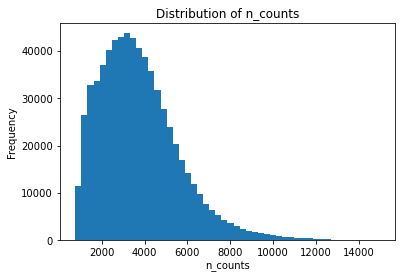

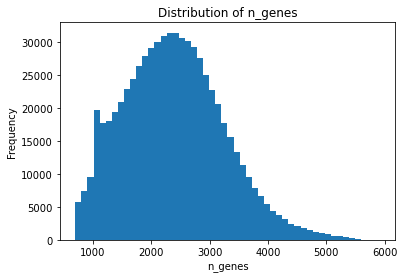

├── X (671453)
├── obs
│   ├── TF (671453)
│   ├── __categories
│   │   ├── TF (3266)
│   │   ├── batch (2)
│   │   ├── batchTF (3266)
│   │   ├── louvain (9)
│   │   └── temp (3265)
│   ├── _index (671453)
│   ├── batch (671453)
│   ├── batchTF (671453)
│   ├── dpt_pseudotime (671453)
│   ├── louvain (671453)
│   ├── m3_pseudotime (671453)
│   ├── n_counts (671453)
│   ├── n_genes (671453)
│   ├── percent_mito (671453)
│   ├── score (671453)
│   └── temp (671453)
└── var
    └── _index (37528)


In [32]:
#f_filt = h5py.File("/home/b-evelyntong/hl/joung_data/TFAtlas_subsample.h5ad", 'r')
# 3/21 using subsample raw instead
f_filt = h5py.File("/home/b-evelyntong/hl/joung_data/TFAtlas_subsample_raw.h5ad", 'r')

# this has information of which TF was overexpressed in each cell, come back later
print(f_filt['obs']['__categories']['TF'][:])
print(f_filt['obs']['__categories']['TF'][:].shape)

# using obs._index for sample ids
print(f_filt['obs']['_index'][:])
print(f_filt['obs']['_index'][:].shape)

# using var._index for gene ids
print(f_filt['var']['_index'][:])
print(f_filt['var']['_index'][:].shape)

# visualize the distribution of n_counts of joung's filtered data
plt.hist(f_filt['obs']['n_counts'][:], bins=50)
plt.xlabel("n_counts")
plt.ylabel("Frequency")
plt.title("Distribution of n_counts")   
plt.show()

# visualize the distribution of n_genes of joung's filtered data
plt.hist(f_filt['obs']['n_genes'][:], bins=50)
plt.xlabel("n_genes")
plt.ylabel("Frequency")
plt.title("Distribution of n_genes")
plt.show()

# sanity checking the structure of joung's h5py file 
h5_tree(f_filt)

In [33]:
pert_dict = f_filt['obs']['__categories']['TF'][:]
pert_dict = [s.decode('utf-8') for s in pert_dict]
pert_dict_TF_code = [re.search(r'TFORF(.*?)\-', s).group(1) for s in pert_dict]
pert_dict_TF_value = [re.search(r'\-([^\-]+)', s).group(1) for s in pert_dict]

# the below investigation was done using filt!
# # if pert id was to match the string concatenated with the orf then the max would not have perfectly matched up with 3265
# # thus, the TF in obs must be referring to the index of the categories TF vector to retrieve perturbation info
# print(pert_id.max())
# print(len(pert_id))
# # note how the 3265th TF was encoded 3550 -- the authors must've dropped a few TF codes
# print(pert_dict[3265])

# building a TF code df just in case
pert_dict_df = pd.DataFrame({
    'TF_code': pert_dict_TF_code,
    'TF_value': pert_dict_TF_value
})


print(pert_dict_df[:2740])


     TF_code TF_value
0       0001    HIF3A
1       0002    HIF3A
2       0003    HIF3A
3       0004    HIF3A
4       0005    HIF3A
...      ...      ...
2735    3019   POU2F1
2736    3020     PAX7
2737    3021     DLX4
2738    3022     RXRG
2739    3023  NEUROD6

[2740 rows x 2 columns]


In [34]:
# pulling metadata from h5py file, the below variables are associated with each observation -- probably 
# mostly junk but I will get them regardless

#METADATA PREP
# 3266
pert_dict = f_filt['obs']['__categories']['TF'][:]
pert_dict = [s.decode('utf-8') for s in pert_dict]

# below becomes columns in pd dataframe
pert_id = f_filt['obs']['TF'][:].astype(int)
pert_list = [pert_dict[i] for i in pert_id]
sample_id = f_filt['obs']['_index'][:].astype(str)
batch_id = f_filt['obs']['batch'][:]
batchTF_id = f_filt['obs']['batchTF'][:]
psdtime = f_filt['obs']['dpt_pseudotime'][:]
lv_clst = f_filt['obs']['louvain'][:]
m3_psdtime = f_filt['obs']['m3_pseudotime'][:]
n_counts = f_filt['obs']['n_counts'][:]
n_genes = f_filt['obs']['n_genes'][:]
pct_mito = f_filt['obs']['percent_mito'][:]
score = f_filt['obs']['score'][:]
temp = f_filt['obs']['temp'][:]

metadata = pd.DataFrame({
    'obs_id': sample_id,
    'pert_id': pert_id,
    'pert_genes': pert_list,
    'batch_id': batch_id,
    'batchTF_id': batchTF_id,
    'psdtime': psdtime,
    'lv_clst': lv_clst,
    'm3_psdtime': m3_psdtime,
    'n_counts': n_counts,
    'n_genes': n_genes,
    'pct_mito': pct_mito,
    'score': score,
    'temp': temp
})

# splitting pert and ctrl, note there are only 2000 controls using mCherry and GFP
ctrl_mCherry = metadata[metadata['pert_genes'].str.contains("mCherry")]
ctrl_GFP = metadata[metadata['pert_genes'].str.contains("GFP")]
ctrl_idx = sorted(set(ctrl_mCherry.index.values).union(ctrl_GFP.index.values))

# creating individual metadatas for each control and pert
metadata_ctrl = metadata.loc[ctrl_idx]
metadata_pert = metadata.loc[~metadata.index.isin(ctrl_idx)]

In [ ]:
# converting the matrix into panda
matrix_filt = f_filt['X'][:].transpose()
gene_ids_filt = f_filt['var']['_index'][:]
sample_ids_filt = f_filt['obs']['_index'][:]
matrix_filt_df = pd.DataFrame(matrix_filt, columns = sample_ids_filt.astype(str), index = gene_ids_filt.astype(str)).astype(np.uint16)
del matrix_filt
# this shows the expression distribution of joung's filtered gene matrix
# plt.hist(matrix_filt_df.mean(axis=0), bins=50)
# plt.xlabel("Mean Gene Expression by Cells")
# plt.ylabel("Frequency") 
# plt.show()
# plt.hist(matrix_filt_df.mean(axis=1), bins=50)
# plt.xlabel("Mean Gene Expression by Genes")
# plt.ylabel("Frequency")
# plt.show()

In [ ]:
# find the sample id of each control and pert and partition matrix by it
ctrl_sample_id = metadata_ctrl['obs_id']
pert_sample_id = metadata_pert['obs_id']
sample_id_order = ctrl_sample_id + pert_sample_id
matrix_filt_df = matrix_filt_df.loc[sample_id_order].reset_index(drop=True)


In [ ]:
metadata = pd.concat([metadata_pert, metadata_ctrl], axis=0).reset_index(inplace=False, drop=True)

mv = matrix.values.flatten() # collapses value into one line for sampling
sampling = sample(range(len(mv)), int(0.001*len(mv)))  # pick 1/1000 of the total samples in the big matrix
mv = mv[sampling]

fig, ax = plt.subplots(figsize=(16,6))
ax.hist(mv)
ax.set_title('Histogram of values')
plt.show()

: 

In [ ]:

#NORMALIZATION
# log + min max normalize, after this the values of matrix will be between 0 and 1
matrix = np.log2(matrix + 1)
scaler = MinMaxScaler((0,1))
matrix = matrix.transpose()
matrix = pd.DataFrame(scaler.fit_transform(matrix), columns = matrix.columns, index = matrix.index)
matrix = matrix.transpose()

#hist of values after lognorm
mv = matrix.values.flatten()
sampling = sample(range(len(mv)), int(0.001*len(mv)))
mv = mv[sampling]

# this gives that most values are at 0.6, and this is a very nice normal distribution 
fig, ax = plt.subplots(figsize=(16,6))
ax.hist(mv)
ax.set_title('Histogram of values')
plt.show()



# EOD 3/20
# this code of block gives npz for Joung, swap in using raw (current is lfc which does not line up with PDGrapher's data) and
# this should give a good lognormed distribution centered around not zero

# next, pass this through export data for torch geometric, possible blocks
# 1) cospos, ppi, I need to still, understand how GNN is implemented here before i'll know how to process the data for it
# 2) check overlap between genes in joung and lincs -- it's only 2000+, don't forget to subset




: 

: 

Next 2 big things
- Use Azure to get the entire Joung data, and see if there's any difference with the one I just saw, and process (note this will probably be used for finetuning)
- Take the current data and see what I need to do to use it as a test dataset

after come back: finish resource table, download data on azure

In [ ]:
### pushing through every line of code that processes the data from its original format into npz format
DATA_ROOT="/home/b-evelyntong/hl/PDGrapher/data/raw/lincs/2022-02-LINCS_Level3/data"

### STEP 1 LOAD
# this chunk loads in instinfo_beta and geneinfo_beta, specific to LINCS, the former for cells and latter for information on genes
# instinfo contains information on which perturbation each cell went through
inst_info = pd.read_csv(os.path.join(DATA_ROOT, 'instinfo_beta.txt'), sep="\t", low_memory=False)
gene_info = pd.read_csv(os.path.join(DATA_ROOT, 'geneinfo_beta.txt'), sep="\t", low_memory=False)

# these steps make sure that inst_info_xxx contains the subset of cells that are either is in the 
# treatment group and perturbed with crispr, or is in the control group and received only a vector
inst_info_xpr = inst_info[np.logical_and(inst_info['pert_type'] == 'trt_xpr',  inst_info['failure_mode'].isna())].reset_index(inplace=False, drop=True)
inst_info_ctl = inst_info[np.logical_and(inst_info['pert_type'] == 'ctl_vector', inst_info['failure_mode'].isna()) ].reset_index(inplace=False, drop=True)

# reads in h5py file and creates a panda dataframe out of it
f = h5py.File(os.path.join(DATA_ROOT, 'level3_beta_trt_xpr_n420583x12328.gctx'), 'r')
matrix_xpr = f['0']['DATA']['0']['matrix'][:].transpose()
gene_ids_xpr = f['0']['META']['ROW']['id'][:]
sample_ids_xpr = f['0']['META']['COL']['id'][:]
matrix_xpr = pd.DataFrame(matrix_xpr, columns = sample_ids_xpr.astype(str), index = gene_ids_xpr.astype(int))
del f

### Control data
f = h5py.File(os.path.join(DATA_ROOT, 'level3_beta_ctl_n188708x12328.gctx'), 'r')
matrix_ctl = f['0']['DATA']['0']['matrix'][:].transpose()
gene_ids_ctl = f['0']['META']['ROW']['id'][:]					#not in the same order as gene_ids_xpr
sample_ids_ctl = f['0']['META']['COL']['id'][:]
matrix_ctl = pd.DataFrame(matrix_ctl, columns = sample_ids_ctl.astype(str), index = gene_ids_ctl.astype(int))
del f

#re-order gene_info based on the order in gene_ids_xpr (rows of data)
gene_info.index = gene_info['gene_id']
gene_info = gene_info.loc[gene_ids_xpr.astype(int)].reset_index(inplace=False, drop=True)

# output here is inst_info_xpr, inst_info_ctl, gene_info, matrix_xpr, matrix_ctl


### STEP 2 FILTER METADATA
#CRISPR
list_ids = list(inst_info_xpr['sample_id'])	#in metadata
matrix_xpr = matrix_xpr[list_ids]	#Filtered data matrix
#CONTROL
list_ids = list(inst_info_ctl['sample_id'])	#in metadata
list_ids = list(set(list_ids).intersection(set(matrix_ctl.columns.astype(str))))	#in metadata and in data matrix (some of metadata are not in data matrix)
inst_info_ctl.index = inst_info_ctl['sample_id']; inst_info_ctl = inst_info_ctl.loc[list_ids].reset_index(inplace=False, drop=True) #remove entries from metadata that are not in data matrix
matrix_ctl = matrix_ctl[list_ids]	#Filtered data matrix
# output here is inst_info_xpr, matrix_xpr, inst_info_ctl, matrix_ctl
# by the end of this, inst_info_xpr is now # perturbed cells as N rows, matrix_xpr is # genes expressed X # perturbed cells. visa versa for ctl



In [ ]:
# STEP 3 FILTER BY CELLLINE (note previous to this they had to figure out which cell lines 
# had more perturbed genes, and found the below so they hard coded it)
# this step is unique to LINCS

#####CRISPR
#Obtain cell lines with the most perturbations (> 4K genes perturbed)
keep_cell_lines = ['A549', 'PC3', 'MCF7', 'A375', 'HT29', 'ES2', 'BICR6', 'YAPC', 'AGS', 'U251MG']
#Find indices of samples that are on the desired cell lines
keep_index = []
for i in range(len(inst_info_xpr)):
    if inst_info_xpr.at[i, 'cell_iname'] in keep_cell_lines:
        keep_index.append(i)
inst_info_xpr = inst_info_xpr.loc[keep_index].reset_index(inplace=False, drop=True) #filter from metadata
list_ids = list(inst_info_xpr['sample_id'])	#obtain sample ID from metadata
matrix_xpr = matrix_xpr[list_ids]	#Filtered data matrix
#####CONTROL
keep_index = []
for i in range(len(inst_info_ctl)):
    if inst_info_ctl.at[i, 'cell_iname'] in keep_cell_lines:
        keep_index.append(i)
inst_info_ctl = inst_info_ctl.loc[keep_index].reset_index(inplace=False, drop=True)  #filter from metadata
list_ids = list(inst_info_ctl['sample_id'])	#obtain sample ID from metadata
matrix_ctl = matrix_ctl[list_ids]	#Filtered data matrix

# STEO 4 FILTER UNKNOWN PERTURBED GENES (indeed unique to xpr, or the treatment group)
# this matches the perturbed gene of each of the cells kept from previous steps to the gene names recorded in gene_info, if it's not there then drop
known_genes = list(set(gene_info['gene_symbol']))
keep_index = []
for i in range(len(inst_info_xpr)):
    if inst_info_xpr.at[i, 'cmap_name'] in known_genes:
        keep_index.append(i)

inst_info_xpr = inst_info_xpr.loc[keep_index].reset_index(inplace=False, drop=True) #filter from metadata
list_ids = list(inst_info_xpr['sample_id'])	#obtain sample ID from metadata
matrix_xpr = matrix_xpr[list_ids]
# only inst_info_xpr, matrix_xpr are returned here


/tmp/ipykernel_1792961/1928344854.py:9: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  matrix = pd.concat([matrix_xpr, matrix_ctl], 1)


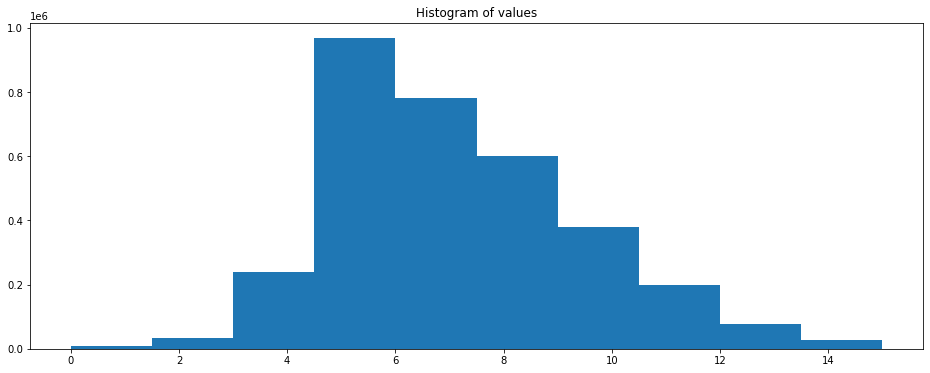

In [ ]:
# STEP 5 NORMALIZE AND SAVE TO NPZ
# note all previous variables were passed here and this function simply returned as it normalizes and saves to a directory. 

# note here they concatenated the ctl and the xpr indices because indeed they wouldn't overlap as the two lists were taken from the inst info in the first place
metadata = pd.concat([inst_info_xpr, inst_info_ctl], axis=0).reset_index(inplace=False, drop=True)
# here they create the file that records each cell id and their metadata attributes
# metadata.to_csv(osp.join(outdir, 'all_metadata.txt'))
# !!!!!! here they concatenated the gene matrices, by extending the cells dimension (gene dimension stays the same)
matrix = pd.concat([matrix_xpr, matrix_ctl], axis=1)
del(matrix_xpr)

# note the below histogram shows that most values (of the .1% of all samples in the concatenated matrix) have a value of ~6
mv = matrix.values.flatten() # collapses value into one line for sampling
sampling = sample(range(len(mv)), int(0.001*len(mv)))  # pick 1/1000 of the total samples in the big matrix
mv = mv[sampling]

fig, ax = plt.subplots(figsize=(16,6))
ax.hist(mv)
ax.set_title('Histogram of values')
plt.show()

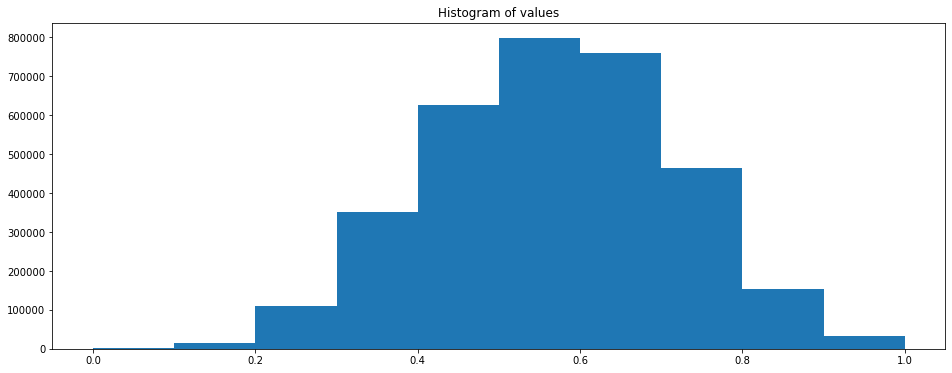

In [ ]:
#NORMALIZATION
# log + min max normalize, after this the values of matrix will be between 0 and 1
matrix = np.log2(matrix + 1)
scaler = MinMaxScaler((0,1))
matrix = matrix.transpose()
matrix = pd.DataFrame(scaler.fit_transform(matrix), columns = matrix.columns, index = matrix.index)
matrix = matrix.transpose()

#hist of values after lognorm
mv = matrix.values.flatten()
sampling = sample(range(len(mv)), int(0.001*len(mv)))
mv = mv[sampling]

# this gives that most values are at 0.6, and this is a very nice normal distribution 
fig, ax = plt.subplots(figsize=(16,6))
ax.hist(mv)
ax.set_title('Histogram of values')
plt.show()

In [37]:
#2. Save data and metadata for each condition and cell line
#Compound + cell lines
#Control + cell lines
outdir = "/home/b-evelyntong/hl/PDGrapher/data/processed/lincs"
metadata.index = metadata['sample_id']
metadata = metadata.loc[matrix.columns]	#sort metadata given by column order in data matrix (and filter samples that have been filtered out from matrix during binarization)
for cell_line in keep_cell_lines:
    for pert_type in ['trt_xpr', 'ctl_vector']:
        metadata_i = metadata[np.logical_and(metadata['cell_iname'] == cell_line, metadata['pert_type'] == pert_type)]
        data_i = matrix[metadata_i.index]
        metadata_i.to_csv(osp.join(outdir, 'cell_line_{}_pert_{}_metadata.txt'.format(cell_line, pert_type)), index=False)
        filename = 'cell_line_{}_pert_{}'.format(cell_line, pert_type)
        np.savez_compressed(osp.join(outdir, filename), data=data_i.values, row_ids = data_i.index, col_ids=data_i.columns)

goal for the next hour: trace back the creation of data/processed/torch_data/real_lognorm/data_forward_A549.pt in single_fold.py

saving the original lincs dataset into npz takes 20 minutes

two things
1 find the meta data for joung -- how do I build the npz + metadata.txt file such that it can be processed into pt with their script with minimal modifications
2 keep understanding how npz is processed into pt

is the ground truth information (the perturbation used) included as a part of the pt file???

if i can figure this out, then I can use scBaseCamp

In [ ]:
print(inst_info[np.logical_and(inst_info['pert_type'] == 'trt_xpr',  inst_info['failure_mode'].isna())].reset_index(inplace=False, drop=True).pert_type)
print(gene_info)

# investigating the overlap of genes between LINCS and Joung et al
lincs_genes = gene_info.gene_symbol.values
print(lincs_genes)
print(lincs_genes.shape)

joung_filt_genes = [b.decode('UTF-8') for b in gene_ids_filt]
print(joung_filt_genes)
print(len(joung_filt_genes))

# venn diagram showing intersection of genes
plt.figure()
venn2([set(lincs_genes), set(joung_filt_genes)], ('LINCS', 'Joung et al'))
plt.show()

0         trt_xpr
1         trt_xpr
2         trt_xpr
3         trt_xpr
4         trt_xpr
           ...   
387312    trt_xpr
387313    trt_xpr
387314    trt_xpr
387315    trt_xpr
387316    trt_xpr
Name: pert_type, Length: 387317, dtype: object
         gene_id gene_symbol       ensembl_id  \
0            750    GAS8-AS1  ENSG00000221819   
1           6315     ATXN8OS              NaN   
2           7503        XIST  ENSG00000229807   
3           8552        INE1  ENSG00000224975   
4           9834      FAM30A  ENSG00000226777   
...          ...         ...              ...   
12323  100287932      TIMM23  ENSG00000265354   
12324  100289678      ZNF783  ENSG00000204946   
12325  100507436        MICA  ENSG00000204520   
12326       9142     TMEM257  ENSG00000221870   
12327      26148    C10orf12  ENSG00000155640   

                                           gene_title       gene_type   src  \
0                                GAS8 antisense RNA 1           ncRNA  NCBI   
1       

# 3/21
- previouly: was able to adapt the pipeline to process joung's data from h5ad to npz -- needs to use raw instead (because the processed is lfc)
- next: run through and produce processed matrix + metadata for raw
- next: understand ppi + lincs and code implementation
- longer + planning: make use of tahoe for finetuning or potentially retraining

- EOD: create da script that processes data for raw, I now have joung data in npz, note the script ran for about 30min (mostly for saving npz)

# 3/25 
- processing ppi edge list and npz into pytorch file

- wrote script to convert raw BIOGRID tab3.txt file into edgelist.txt which will be read into nx

- EOD: understood how npz is processed into pt, migrated that code to notebook, next step curate this code for joung et al

In [ ]:
path_edge_list = "/home/b-evelyntong/hl/PDGrapher/data/raw/ppi/2022-03-PPI/BIOGRID-MV-Physical-4.4.207.tab3.txt"

df = pd.read_csv(path_edge_list, sep='\t')
print(df.shape)
print(df.columns)
df = df[(df['Organism ID Interactor A'] == 9606) & (df['Organism ID Interactor B'] == 9606)]
print(df.shape)
edges = df[['Official Symbol Interactor A', 'Official Symbol Interactor B']].dropna()
print(edges.shape)
edges = edges[edges['Official Symbol Interactor A'] != edges['Official Symbol Interactor B']]
print(edges.shape)
edges = edges.drop_duplicates()
print(edges.shape)

In [32]:
# quickly outputting a gene list from joung
with h5py.File('/home/b-evelyntong/hl/joung_data/TFAtlas_subsample_raw.h5ad', 'r') as f:
    gene_ids = f['var']['_index'][:]
gene_ids = [s.decode('utf-8') for s in gene_ids]
print(gene_ids)

with open('/home/b-evelyntong/hl/joung_data/gene_info.txt', 'w', encoding='utf-8') as out_file:
    for gene in gene_ids:
        out_file.write(gene + '\n')

['A1BG', 'A1BG-AS1', 'A1CF', 'A2M', 'A2M-AS1', 'A2ML1', 'A2MP1', 'A3GALT2', 'A4GALT', 'A4GNT', 'AA06', 'AAAS', 'AACS', 'AACSP1', 'AADAC', 'AADACL2', 'AADACL2-AS1', 'AADACL3', 'AADACL4', 'AADACP1', 'AADAT', 'AAED1', 'AAGAB', 'AAK1', 'AAMDC', 'AAMP', 'AANAT', 'AAR2', 'AARD', 'AARS', 'AARS2', 'AARSD1', 'AASDH', 'AASDHPPT', 'AASS', 'AATBC', 'AATF', 'AATK', 'AATK-AS1', 'ABALON', 'ABAT', 'ABCA1', 'ABCA10', 'ABCA11P', 'ABCA12', 'ABCA13', 'ABCA17P', 'ABCA2', 'ABCA3', 'ABCA4', 'ABCA5', 'ABCA6', 'ABCA7', 'ABCA8', 'ABCA9', 'ABCA9-AS1', 'ABCB1', 'ABCB10', 'ABCB11', 'ABCB4', 'ABCB5', 'ABCB6', 'ABCB7', 'ABCB8', 'ABCB9', 'ABCC1', 'ABCC10', 'ABCC11', 'ABCC12', 'ABCC13', 'ABCC2', 'ABCC3', 'ABCC4', 'ABCC5', 'ABCC5-AS1', 'ABCC6', 'ABCC6P1', 'ABCC6P2', 'ABCC8', 'ABCC9', 'ABCD1', 'ABCD2', 'ABCD3', 'ABCD4', 'ABCE1', 'ABCF1', 'ABCF2', 'ABCF3', 'ABCG1', 'ABCG2', 'ABCG4', 'ABCG5', 'ABCG8', 'ABHD1', 'ABHD10', 'ABHD11', 'ABHD11-AS1', 'ABHD12', 'ABHD12B', 'ABHD13', 'ABHD14A', 'ABHD14A-ACY1', 'ABHD14B', 'ABHD15', 

Number of nodes in PPI network:  10635 

Number of edges in PPI network:  63472 

Keeping only PPI nodes that are in LINCS: 8014

Keeping only PPI nodes that are in TF Atlas: 10458

['GAS8-AS1', 'ATXN8OS', 'XIST', 'INE1', 'FAM30A', 'LINC01587', 'HCG9', 'DSCR4', 'LINC01565', 'FAM215A', 'LINC02249', 'LINC00588', 'TCL6', 'FOXN3-AS2', 'LINC00652', 'LOC51145', 'IGF2-AS', 'WT1-AS', 'KCNQ1DN', 'LINC00474', 'BPESC1', 'TTTY15', 'RHPN1-AS1', 'LINC00574', 'HEXA-AS1', 'ASMTL-AS1', 'ZNF205-AS1', 'MCM3AP-AS1', 'SMG7-AS1', 'FAM182A', 'NOP14-AS1', 'LINC00939', 'LINC01136', 'GS1-600G8.3', 'CADM3-AS1', 'FAM66D', 'NDUFB2-AS1', 'CELP', 'CYP2B7P', 'ADAM3A', 'DHFRP3', 'GBAP1', 'GUCY1B2', 'HBBP1', 'PIN1P1', 'PMCHL1', 'PMS2P5', 'PRKY', 'SAA3P', 'TRPC2', 'MBL1P', 'TAAR3P', 'RAB9BP1', 'CLCA3P', 'HNRNPA3P1', 'PPBPP2', 'PPY2P', 'PYY2', 'BRD7P3', 'OR1F2P', 'PTTG3P', 'DUX4L8', 'CES1P1', 'BTN2A3P', 'LRRC37A4P', 'RPL23AP32', 'LILRP2', 'ZNF702P', 'LPAL2', 'NACA4P', 'POLR2J4', 'AOC4P', 'HTR7P1', 'VENTXP1', 'RBMY2FP', '

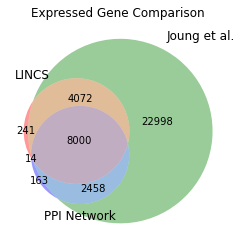

Number of connected componens:	307

After keeping only biggest CC:

stats: 7632 nodes, 47833 edges, 0.0016426226247511324 density





In [8]:
# they took the intersection between lincs and ppi genes, I should check how much overlap they had and take intersection with joung data
ppi = nx.read_edgelist( '/home/b-evelyntong/hl/PDGrapher/data/raw/ppi/2022-03-PPI/processed/ppi_edgelist.txt')
gene_info_lincs = pd.read_csv('/home/b-evelyntong/hl/PDGrapher/data/raw/lincs/2022-02-LINCS_Level3/data/geneinfo_beta.txt', sep="\t", low_memory=False)
gene_info_joung = pd.read_csv('/home/b-evelyntong/hl/joung_data/gene_info.txt', header=None, names=['gene'])

print('Number of nodes in PPI network: ', ppi.number_of_nodes(), '\n')
print('Number of edges in PPI network: ', ppi.number_of_edges(), '\n')
# print(gene_info_lincs.head)
# print(gene_info_joung.head)

ppi_lincs = ppi.subgraph(gene_info_lincs['gene_symbol'].tolist())
print('Keeping only PPI nodes that are in LINCS: {}\n'.format(ppi_lincs.number_of_nodes()))

ppi_joung = ppi.subgraph(gene_info_joung['gene'].tolist())
print('Keeping only PPI nodes that are in TF Atlas: {}\n'.format(ppi_joung.number_of_nodes()))

print(gene_info_lincs['gene_symbol'].tolist())
print(gene_info_joung['gene'].tolist())
print(list(ppi.nodes()))

# Convert lists to sets
lincs_genes = set(gene_info_lincs['gene_symbol'].tolist())
joung_genes = set(gene_info_joung['gene'].tolist())
ppi_nodes = set(ppi.nodes())

plt.figure()
venn3([lincs_genes, joung_genes, ppi_nodes], set_labels=('LINCS', 'Joung et al.', 'PPI Network'))
plt.title('Expressed Gene Comparison')
plt.show()



# ok now we can continue to export
# ppi = ppi.subgraph(gene_info_joung['gene'].tolist())
ppi = ppi.subgraph(gene_info_lincs['gene_symbol'].tolist())
ccs = [len(c) for c in sorted(nx.connected_components(ppi), key=len, reverse=True)]
print('Number of connected componens:\t{}\n'.format(len(ccs)))
Gcc = sorted(nx.connected_components(ppi), key=len, reverse=True)
ppi = ppi.subgraph(Gcc[0])
print(('After keeping only biggest CC:\n'))
print(('stats: {} nodes, {} edges, {} density\n\n\n'.format(ppi.number_of_nodes(), ppi.number_of_edges(), nx.density(ppi))))

#Saves ppi
outdir = '/home/b-evelyntong/hl/PDGrapher/data/processed/ppi'
os.makedirs(outdir, exist_ok=True)
ppi_f = osp.join(outdir, 'ppi_all_genes_edgelist.txt')

nx.write_edgelist(ppi, ppi_f, data=False) 


In [28]:
# fixing gene_info.txt real quick (from process_data.py)
f = h5py.File('/home/b-evelyntong/hl/PDGrapher/data/raw/lincs/2022-02-LINCS_Level3/data/level3_beta_trt_xpr_n420583x12328.gctx', 'r')
gene_info = pd.read_csv('/home/b-evelyntong/hl/PDGrapher/data/raw/lincs/2022-02-LINCS_Level3/data/geneinfo_beta.txt', sep="\t", low_memory=False)
gene_ids_xpr = f['0']['META']['ROW']['id'][:]
gene_info.index = gene_info['gene_id']
gene_info = gene_info.loc[gene_ids_xpr.astype(int)].reset_index(inplace=False, drop=True)
gene_info.to_csv("/home/b-evelyntong/hl/PDGrapher/data/processed/lincs/gene_info.txt", index=False)

In [ ]:
# we now proceed to explore export_data_for_torch_geometric.py
# main has 5 steps: load_ppi, load_gene_metadata, load_data, filter_data, assemble_data_list, save_data
# we will first try with lincs, once we get a hang of how things are supposed to go, we swap in with joung et al

data_root_dir = "/home/b-evelyntong/hl/PDGrapher/data/processed/lincs"
for cell_line, healthy in zip(['A375', 'HT29', 'ES2', 'BICR6', 'YAPC', 'AGS', 'U251MG'], [None, None, None, None, None, None, None]):
# load_ppi
	ppi = nx.read_edgelist("/home/b-evelyntong/hl/PDGrapher/data/processed/ppi/ppi_all_genes_edgelist.txt")

# load_gene_metadata (supposedly only gene_info is used)
	gene_info = pd.read_csv("/home/b-evelyntong/hl/PDGrapher/data/processed/lincs/gene_info.txt")
	
# load_data
	#Loads data matrix (observational)
	file = osp.join(data_root_dir, 'cell_line_{}_pert_ctl_vector.npz'.format(cell_line))
	file_metadata = osp.join(data_root_dir, 'cell_line_{}_pert_ctl_vector_metadata.txt'.format(cell_line))
	obs_metadata = pd.read_csv(file_metadata)
	with np.load(file, allow_pickle=True) as arr:
		obs_data =arr['data']
		col_ids = arr['col_ids']
		row_ids = arr['row_ids']
	obs_data = pd.DataFrame(obs_data, columns= col_ids, index=row_ids)
	print('Number of observational datapoints:\t{}\n'.format(len(obs_metadata)))
	#Loads data matrix (interventional)
	file = osp.join(data_root_dir, 'cell_line_{}_pert_trt_xpr.npz'.format(cell_line))
	file_metadata = osp.join(data_root_dir, 'cell_line_{}_pert_trt_xpr_metadata.txt'.format(cell_line))
	int_metadata = pd.read_csv(file_metadata)
	with np.load(file, allow_pickle=True) as arr:
		int_data =arr['data']
		col_ids = arr['col_ids']
		row_ids = arr['row_ids']
	int_data = pd.DataFrame(int_data, columns= col_ids, index=row_ids)
	print('Number of interventional datapoints:\t{}\n'.format(len(int_metadata)))
	
# filter_data
	healthy_data = None
	healthy_metadata = None
	cosmic_mutations = None
	#1.Filter out obs and int data to keep only genes that are in the PPI
	gene_symbols_in_ppi = list(ppi.nodes())
	#####
	# this code was buggy for keying non-existent gene in ppi
	# BECAUSE I SHORT CUTTED THE LOOP and gene_info was modified in place LOL
	dict_symbol_id = dict(zip(gene_info['gene_symbol'], gene_info['gene_id']))
	gene_ids_in_ppi = [dict_symbol_id[i] for i in gene_symbols_in_ppi]
	gene_info.index = gene_info['gene_id']; gene_info = gene_info.loc[gene_ids_in_ppi].reset_index(inplace=False, drop=True)
	obs_data = obs_data.loc[gene_ids_in_ppi]
	int_data = int_data.loc[gene_ids_in_ppi]
	######
	if healthy_data is not None:
		healthy_data = healthy_data.loc[gene_ids_in_ppi]
	if cosmic_mutations is not None:
		cosmic_mutations = pd.DataFrame(cosmic_mutations)[[e in gene_ids_in_ppi for e in cosmic_mutations]][0].tolist()
	#2. Filter out samples whose interventions are not in the remaining genes (those in the PPI)
	keep = []
	for i, gene_symbol in enumerate(int_metadata['cmap_name']):
		if gene_symbol in gene_symbols_in_ppi:
			keep.append(int_metadata.at[i, 'sample_id'])
	int_metadata.index = int_metadata['sample_id']; int_metadata = int_metadata.loc[keep].reset_index(inplace=False, drop=True)
	int_data = int_data[keep]
	print('Number of interventional datapoints after keeping only those with perturbed genes in PPI:\t{}\n'.format(len(int_metadata)))

# assemble_data_list
	print('Assembling data...\n')

	#First, we re-index genes in PPI and data
		#Gene symbol to index to ordered index
	gene_symbol_to_index = dict(zip(gene_info['gene_symbol'], gene_info['gene_id']))
	gene_index_to_ordered_index = dict(zip(gene_info['gene_id'], range(len(gene_info))))
	gene_info['ordered_index'] = [gene_index_to_ordered_index[i] for i in gene_info['gene_id']]


		#Reindex genes in PPI, obs_data, int_data, healty_data, and cosmic_mutations
	ppi = nx.relabel_nodes(ppi, gene_symbol_to_index)
	ppi = nx.relabel_nodes(ppi, gene_index_to_ordered_index)
	int_data.index = [gene_index_to_ordered_index[i] for i in int_data.index]
	int_data = int_data.sort_index(inplace=False)
	obs_data.index = [gene_index_to_ordered_index[i] for i in obs_data.index]
	obs_data = obs_data.sort_index(inplace=False)
	if healthy_data is not None:
		healthy_data.index = [gene_index_to_ordered_index[i] for i in healthy_data.index]
		healthy_data = healthy_data.sort_index(inplace=False)
	if cosmic_mutations is not None:
		cosmic_mutations = [gene_index_to_ordered_index[i] for i in cosmic_mutations]
		cosmic_vector = np.zeros(len(healthy_data))
		cosmic_vector[cosmic_mutations] = 1


	#Assembling samples
	edge_index = torch.LongTensor(np.array(ppi.edges()).transpose())
	edge_index = add_remaining_self_loops(edge_index)[0]
	edge_index = to_undirected(edge_index)
	number_of_nodes = ppi.number_of_nodes()

	#remove incoming edges to perturbed nodes (mutated nodes)
	# mask = [e not in cosmic_mutations for e in edge_index[1,:]]
	# edge_index_mutilated = edge_index[:, mask]
	# edge_index_mutilated = add_remaining_self_loops(edge_index_mutilated)[0]

	dict_forward_sample_and_mutations = dict() #saves the mutation vector used in forward



	forward_data_list = []
	if healthy_data is not None: #we only build forward data when we have healthy samples
		#FORWARD DATA - healthy_data, cosmic_vector, obs_data
			#each Data object will be a pairing of a random healthy_data column, the cosmic mutations, and a obs_data column
			#will have as many as obs_data columns
		i = 0
		order = np.array(range(healthy_data.shape[1]))
		np.random.shuffle(order)
		for sample_id in obs_data.columns:
			#sample a random healthy GE vector
			i = i % healthy_data.shape[1]
			sample_index = order[i]
			healthy_sample = healthy_data[healthy_data.columns[i]].values
			healthy = torch.Tensor(healthy_sample)
			#mutation
			#randomize mutations. First select the percentage of mutations to include, then select the mutations
			perc_to_include = np.random.choice([0.25, 0.50, 0.75, 1], 1).item()
			if int_metadata['cell_mfc_name'][0].split('.')[0] == 'PC3':
				perc_to_include = 1
			cosmic_mutations_i = np.random.choice(cosmic_mutations, int(len(cosmic_mutations)* perc_to_include))
			cosmic_vector = np.zeros(len(healthy_data))
			cosmic_vector[cosmic_mutations_i] = 1
			mutations = torch.Tensor(cosmic_vector)
			#diseased
			diseased = torch.Tensor(obs_data[sample_id])
			data = Data(healthy = healthy, mutations=mutations, diseased=diseased, gene_symbols = gene_info['gene_symbol'].tolist())
			data.num_nodes = number_of_nodes
			forward_data_list.append(data)
			#Save 
			i +=1
			dict_forward_sample_and_mutations[sample_id] = mutations
		print('finished data forward')


	#BACKWARD DATA - obs_data, int_data
	#dict sample id: perturbed gene ordered index
	dict_sample_id_perturbed_gene_ordered_index = dict()
	for sample_id, cmap_name in zip(int_metadata['sample_id'], int_metadata['cmap_name']):
		dict_sample_id_perturbed_gene_ordered_index[sample_id] = gene_index_to_ordered_index[gene_symbol_to_index[cmap_name]]


		#these are helpers to sample from obs_data
	order = np.array(range(obs_data.shape[1]))
	np.random.shuffle(order)
	i = 0
	#shuffle obs data columns
	backward_data_list = []
	unique_names_pert = set()
	for sample_id in int_data.columns:
		binary_indicator_perturbation = np.zeros(len(int_data))
		binary_indicator_perturbation[dict_sample_id_perturbed_gene_ordered_index[sample_id]] = 1
		#Get a random pre-intervention sample
		i = i % obs_data.shape[1]
		sample_index = order[i]
		obs_sample_id = obs_data.columns[i]
		obs_sample = obs_data[obs_data.columns[i]].values
		#concat initial node features and perturbation indicator
		diseased = torch.Tensor(obs_sample)
		intervention = torch.Tensor(binary_indicator_perturbation)
		if healthy_data is not None:
			mutations = dict_forward_sample_and_mutations[obs_sample_id]
		else:
			mutations = torch.Tensor(np.zeros(len(diseased)))
		# torch.Tensor(np.stack([obs_sample, binary_indicator_perturbation], 1))
		#post-intervention
		treated = torch.Tensor(int_data[sample_id])
		#remove incoming edges to perturbed node
		# perturbed_node = dict_sample_id_perturbed_gene_ordered_index[sample_id]
		# edge_index_mutilated = edge_index[:, edge_index[1,:] != perturbed_node]
		
		gene_name = int_metadata[int_metadata['sample_id'] == sample_id]['cmap_name'].item()
		unique_names_pert.add(gene_name)
		data = Data(perturbagen_name = gene_name, diseased = diseased, intervention=intervention, treated = treated, gene_symbols = gene_info['gene_symbol'].tolist(), mutations = mutations)
		data.num_nodes = number_of_nodes
		backward_data_list.append(data)
		i +=1

	print('Samples forward:\t{}\n'.format(len(forward_data_list)))
	print('Samples backward:\t{}\n'.format(len(backward_data_list)))
	print('Unique perturbagens:\t{}\n'.format(len(unique_names_pert)))

# save_data
	print('Saving data {} ...\n\n\n'.format(cell_line))
	
	outdir = '/home/b-evelyntong/hl/PDGrapher/data/processed/torch_data/real_lognorm_test'
	torch.save(forward_data_list, osp.join(outdir, 'data_forward_{}.pt'.format(cell_line)))
	torch.save(backward_data_list, osp.join(outdir, 'data_backward_{}.pt'.format(cell_line)))
	torch.save(edge_index, osp.join(outdir, 'edge_index_{}.pt'.format(cell_line)))


Number of observational datapoints:	4777

Number of interventional datapoints:	23523

Number of interventional datapoints after keeping only those with perturbed genes in PPI:	16091

Assembling data...

Samples forward:	0

Samples backward:	16091

Unique perturbagens:	2638

Saving data A375 ...



Number of observational datapoints:	4235

Number of interventional datapoints:	22220

Number of interventional datapoints after keeping only those with perturbed genes in PPI:	14750

Assembling data...

Samples forward:	0

Samples backward:	14750

Unique perturbagens:	2635

Saving data HT29 ...



Number of observational datapoints:	1277

Number of interventional datapoints:	25540

Number of interventional datapoints after keeping only those with perturbed genes in PPI:	17558

Assembling data...

Samples forward:	0

Samples backward:	17558

Unique perturbagens:	2601

Saving data ES2 ...



Number of observational datapoints:	1362

Number of interventional datapoints:	22981

Number of interven

In [ ]:
# attempting to make export_data_for_torch_geometric.py for joung's data
matrix_file_path = "/home/b-evelyntong/hl/joung_data/03-21-t1/matrix.csv.npz"
metadata_file_path = "/home/b-evelyntong/hl/joung_data/03-21-t1/metadata.csv"

# load_ppi
ppi = nx.read_edgelist("/home/b-evelyntong/hl/PDGrapher/data/processed/ppi/ppi_all_genes_edgelist_joung.txt")

# load_gene_metadata (supposedly only gene_info is used)
gene_info = pd.read_csv("/home/b-evelyntong/hl/joung_data/gene_info.txt", header=None)
# gene_info = pd.read_csv("/home/b-evelyntong/hl/PDGrapher/data/processed/lincs/gene_info.txt")

# load_data
# loads in the actual matrix file, 44GB npz takes 3.5min and ~100GB memory
obs_metadata = pd.read_csv(metadata_file_path)
with np.load(matrix_file_path, allow_pickle=True) as arr:
    obs_data =arr['data']
    col_ids = arr['col_ids']
    row_ids = arr['row_ids']
obs_data = pd.DataFrame(obs_data, columns= col_ids, index=row_ids)
print('Number of observational datapoints:\t{}\n'.format(len(obs_metadata)))

# split my data into "observational" (GFP and mCherry) and "interventional"
ctrl_index = obs_metadata[obs_metadata['pert_gene'].str.contains("mCherry|GFP")]['_index']
pert_index = obs_metadata[~obs_metadata['pert_gene'].str.contains("mCherry|GFP")]['_index']

ctrl_data = obs_data[ctrl_index]
pert_data = obs_data[pert_index]

ctrl_metadata = obs_metadata[obs_metadata['pert_gene'].str.contains("mCherry|GFP")]
pert_metadata = obs_metadata[~obs_metadata['pert_gene'].str.contains("mCherry|GFP")]

del obs_data

#1.Filter out obs and int data to keep only genes that are in the PPI
gene_symbols_in_ppi = list(ppi.nodes())
gene_symbols = gene_info[0].values.tolist()
gene_symbols_in_ppi = list(set(gene_symbols) & set(gene_symbols_in_ppi))

ctrl_data = ctrl_data.loc[gene_symbols_in_ppi]
pert_data = pert_data.loc[gene_symbols_in_ppi]

gene_id_sym_index = pert_metadata[['pert_id', 'pert_gene', '_index']]
gene_id_sym_index = gene_id_sym_index.rename(columns={'pert_gene': 'pert_iso'})
extracted_genes = [re.split('-', gene)[1] if '-' in gene else gene for gene in gene_id_sym_index['pert_iso']]
gene_id_sym_index['pert_gene'] = extracted_genes


#2. Filter out samples whose perturbations are not in the remaining genes (those in the PPI)
keep = []
for i, gene_symbol in gene_id_sym_index[['_index', 'pert_gene']].iterrows():
    if gene_symbol['pert_gene'] in gene_symbols_in_ppi:
        keep.append(gene_symbol['_index'])

pert_metadata.index = pert_metadata['_index']; pert_metadata = pert_metadata.loc[keep].reset_index(inplace=False, drop=True)
pert_data = pert_data[keep]
gene_id_sym_index = gene_id_sym_index[gene_id_sym_index['_index'].isin(keep)]
print('Number of interventional datapoints after keeping only those with perturbed genes in PPI:\t{}\n'.format(len(pert_metadata)))

all_genes = pert_data.index

unique_sym_id = gene_id_sym_index[['pert_id', 'pert_gene']].drop_duplicates()
gene_symbol_to_index = dict(zip(unique_sym_id['pert_gene'], unique_sym_id['pert_id']))
gene_index_to_ordered_index = dict(zip(unique_sym_id['pert_id'], range(len(unique_sym_id))))
gene_symbol_to_ordered_index = dict(zip(unique_sym_id['pert_gene'], range(len(unique_sym_id))))
gene_info = unique_sym_id.copy() 
gene_info['ordered_index'] = [gene_index_to_ordered_index[i] for i in gene_info['pert_id']]

real_gene_to_index = dict(zip(all_genes, range(len(all_genes))))
ppi = nx.relabel_nodes(ppi, real_gene_to_index)

pert_data.index = [real_gene_to_index[i] for i in pert_data.index]
pert_data = pert_data.sort_index(inplace=False)
ctrl_data.index = [real_gene_to_index[i] for i in ctrl_data.index]
ctrl_data = ctrl_data.sort_index(inplace=False)

#Assembling samples
print("begin assembling data")
edge_index = torch.LongTensor(np.array(ppi.edges()).transpose())
edge_index = add_remaining_self_loops(edge_index)[0]
edge_index = to_undirected(edge_index)
number_of_nodes = ppi.number_of_nodes()

#dict sample id: perturbed gene ordered index
dict_sample_id_perturbed_gene_ordered_index = dict()
for sample_index, pert_gene in zip(gene_id_sym_index['_index'], gene_id_sym_index['pert_gene']):
    dict_sample_id_perturbed_gene_ordered_index[sample_index] = real_gene_to_index[pert_gene]


        pert_id pert_gene  ordered_index
246        1681    POU2F2              0
1351       2383      PAX3              1
1453       1434    ZNF197              2
2458       1338     FOXN3              3
2482        156      RELA              4
...         ...       ...            ...
667205     1185     KLF15           2220
667262     2519    ZNF281           2221
667280      388   ZSCAN30           2222
667413       72    KCNIP3           2223
668500      191     FOXP3           2224

[2225 rows x 3 columns]


In [ ]:
#these are helpers to sample from obs_data
order = np.array(range(ctrl_data.shape[1]))
np.random.shuffle(order)
i = 0
#shuffle obs data columns
backward_data_list = []
unique_names_pert = set()
print("processing all samples...")
for sample_id in tqdm(pert_data.columns, desc="Processing Samples"):
    binary_indicator_perturbation = np.zeros(len(pert_data))
    binary_indicator_perturbation[dict_sample_id_perturbed_gene_ordered_index[sample_id]] = 1
    #Get a random pre-intervention sample
    i = i % ctrl_data.shape[1]
    sample_index = order[i]
    ctrl_sample_id = ctrl_data.columns[i]
    ctrl_sample = ctrl_data[ctrl_data.columns[i]].values
    #concat initial node features and perturbation indicator
    control = torch.Tensor(ctrl_sample)
    perturbation = torch.Tensor(binary_indicator_perturbation)
    mutations = torch.Tensor(np.zeros(len(control)))
    # torch.Tensor(np.stack([obs_sample, binary_indicator_perturbation], 1))
    #post-intervention
    perturbed = torch.Tensor(pert_data[sample_id])
    #remove incoming edges to perturbed node
    # perturbed_node = dict_sample_id_perturbed_gene_ordered_index[sample_id]
    # edge_index_mutilated = edge_index[:, edge_index[1,:] != perturbed_node]
    
    gene_name = gene_id_sym_index[gene_id_sym_index['_index'] == sample_id]['pert_gene'].item()
    unique_names_pert.add(gene_name)
    data = Data(perturbagen_name = gene_name, control = control, perturbation=perturbation, perturbed = perturbed, gene_symbols = list(all_genes), mutations = mutations)
    data.num_nodes = number_of_nodes
    backward_data_list.append(data)
    i +=1

# print('Samples forward:\t{}\n'.format(len(forward_data_list)))
print('Samples backward:\t{}\n'.format(len(backward_data_list)))
print('Unique perturbagens:\t{}\n'.format(len(unique_names_pert)))

print('Saving data ...\n\n\n')
	
outdir = '/home/b-evelyntong/hl/joung_data/torch_data'
# torch.save(forward_data_list, osp.join(outdir, 'data_forward.pt'))
torch.save(backward_data_list, osp.join(outdir, 'data_backward.pt'))
torch.save(edge_index, osp.join(outdir, 'edge_index.pt'))

Processing Samples:   7%|▋         | 35913/491913 [17:27<3:41:40, 34.28it/s] 


KeyboardInterrupt: 

# 3/27
- consider training a model with LINCS data and evaluate on joung data
    - note potentially incompatible dimensions, lincs < joung so we need to fill 0's?

In [4]:
# what perturbation is in lincs and what is in joung? are they really that different?
lincs_metadata = pd.read_csv("/home/b-evelyntong/hl/PDGrapher/data/raw/lincs/2022-02-LINCS_Level3/data/instinfo_beta.txt", sep="\t", low_memory=False)
lincs_metadata = lincs_metadata[np.logical_and(lincs_metadata['pert_type'].isin(['trt_xpr', 'ctl_vector']), lincs_metadata['failure_mode'].isna())].reset_index(inplace=False, drop=True)
lincs_pert_genes = lincs_metadata['cmap_name'].to_list()

joung_metadata = pd.read_csv("/home/b-evelyntong/hl/joung_data/03-21-t1/metadata.csv", low_memory=False)
joung_pert_genes = [re.split('-', gene)[1] if '-' in gene else gene for gene in joung_metadata['pert_gene']]


['DLX4', 'DLX4', 'DLX4', 'DLX4']
['GFP', 'LUCIFERASE', 'LUCIFERASE', 'GFP']
{'VSX1', 'GLIS2', 'GSC', 'AFF4', 'MTA2', 'ZNF567', 'ZNF697', 'SOX12', 'PIAS3', 'NR5A1', 'SLC2A4RG', 'GMEB2', 'HES2', 'ZNF630', 'OTX1', 'ZNF471', 'NR5A2', 'ZBED4', 'ZNF512B', 'FOXL2', 'PBX2', 'TBX4', 'ATF1', 'GTF2A2', 'SOX5', 'FOXC1', 'PBX1', 'THAP10', 'FOXF1', 'ZNF436', 'ZNF660', 'ZNF136', 'PRDM6', 'RUNX1T1', 'HOXC9', 'T', 'MLLT10', 'MAFA', 'ZNF488', 'ZBED3', 'ZNF597', 'ENO1', 'ZNF256', 'OLIG3', 'ZNF584', 'ZNF366', 'GTF2H3', 'THAP9', 'SOX18', 'PAX5', 'FOXJ1', 'ZNF740', 'DLX4', 'HDX', 'ZNF688', 'ZNF580', 'HMX1', 'CREB3L2', 'BLZF1', 'ZNF84', 'LBX2', 'ZNF215', 'FOXA1', 'FOXP4', 'ZBTB34', 'FOXH1', 'NHLH1', 'ZNF658', 'ZKSCAN4', 'DNAJC2', 'CDCA7L', 'ZNF768', 'FOXQ1', 'NFYC', 'PARP1', 'ZNF530', 'BID', 'TPRX1', 'GTF2IRD2B', 'HNF1A', 'GBX2', 'BBX', 'ZNF85', 'FOXD4L4', 'ZNF577', 'MEOX2', 'SMAD1', 'PAXBP1', 'TULP1', 'TBX1', 'MAF', 'GATA4', 'NANOG', 'XBP1', 'NME2', 'LCOR', 'MYCL', 'ZNF480', 'HES3', 'SFPQ', 'SOX15', 'WIZ', 

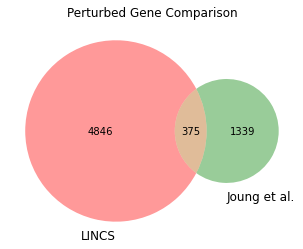

In [9]:
print(joung_pert_genes[1:5])
print(lincs_pert_genes[1:5])
print(set(joung_pert_genes))
print(set(lincs_pert_genes))

plt.figure()
venn2([set(lincs_pert_genes), set(joung_pert_genes)], ('LINCS', 'Joung et al.'))
plt.title('Perturbed Gene Comparison')
plt.show()


In [ ]:
# Open the file in read mode
input_file = "/home/b-evelyntong/hl/joung_data/TFAtlas_subsample_raw.h5ad"
output_file = "/home/b-evelyntong/hl/joung_data/TFAtlas_subsample_lognorm.h5ad"

# Compute total counts per cell (this might require a chunked approach for very large datasets)
with h5py.File(input_file, 'r') as f:
    # If possible, do a chunked computation of total counts
    total_counts = np.sum(f['X'][:], axis=1)

# Compute normalization factor (median total counts)
median_total_counts = np.median(total_counts)

# Read the AnnData object
adata = sc.read_h5ad(input_file, backed='r')

# Create a copy to avoid modifying the original
adata_log = adata.copy()

# Log normalize (in a memory-efficient way)
def log_normalize(X):
    # Normalize by total counts
    normalized = X / total_counts[:, np.newaxis] * median_total_counts
    # Log transform
    return np.log1p(normalized)

# If the dataset is still too large, you might need to process in chunks
# This is a simplified version - you may need to adjust based on your specific memory constraints
adata_log.X = log_normalize(adata.X[:])

# Save the log-normalized AnnData
adata_log.write(output_file)

print("Log normalization complete. Saved to:", output_file)

reading in h5ad...
selecting cells...
extracting cells...
plotting...


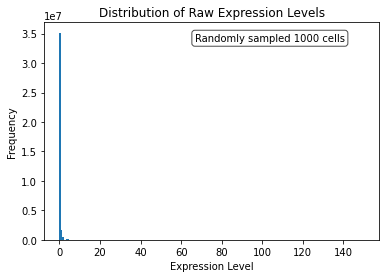

In [19]:
# creating more QC plots to check expression

print("reading in h5ad...")
# Read the h5ad file
adata = sc.read_h5ad("/home/b-evelyntong/hl/joung_data/TFAtlas_subsample_raw.h5ad", backed = 'r')

print("selecting cells...")
# Randomly select cells
np.random.seed(702)
n_cells = 1000
selected_cells = np.random.choice(adata.shape[0], size=n_cells, replace=False)
selected_cells = np.sort(selected_cells)

print("extracting cells...")
# Extract expression values for selected cells
sample_data = adata.X[selected_cells, :]

dat_to_plot = sample_data.flatten()

print("plotting...")
# Plot raw expression distribution
plt.figure()
plt.hist(dat_to_plot, bins=200)
plt.xlabel("Expression Level")
plt.ylabel("Frequency")
plt.title("Distribution of Raw Expression Levels")
plt.text(0.45, 0.95, "Randomly sampled 1000 cells", 
         transform=plt.gca().transAxes, 
         verticalalignment='top', 
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))
plt.show()

# print("log norm...")
# # Log normalization
# adata_log = adata.copy()
# sc.pp.log1p(adata_log)  # log(x+1) transformation

# print("plotting...")
# # Plot log-normalized expression distribution
# sample_data_log = adata_log.X[selected_cells, :]
# plt.figure()
# plt.hist(sample_data_log.flatten())
# plt.xlabel("Log-Normalized Expression Level")
# plt.ylabel("Frequency")
# plt.title("Distribution of Log-Normalized Expression Levels")
# plt.close()

getting shape..
loading selected cells...
reading selected cells...
plotting...


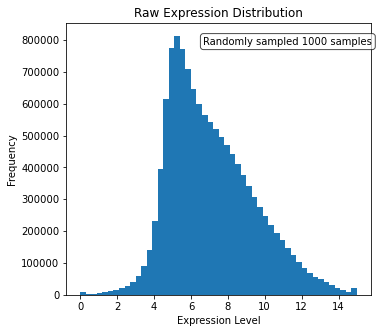

In [3]:
with h5py.File('/home/b-evelyntong/hl/PDGrapher/data/raw/lincs/2022-02-LINCS_Level3/data/level3_beta_trt_xpr_n420583x12328.gctx', 'r') as f:
    # Get total number of columns (samples)
    n_cells = 1000
    print("getting shape..")
    total_samples = f['0']['DATA']['0']['matrix'][:].transpose().shape[1]
    
    print("loading selected cells...")
    # Randomly select cells
    np.random.seed(seed=702)
    selected_cells = np.sort(np.random.choice(total_samples, 
                                                size=n_cells, 
                                                replace=False))
    
    print("reading selected cells...")
    # Read selected columns
    sample_data = f['0']['DATA']['0']['matrix'][:].transpose()[:, selected_cells]

    print("plotting...")
    
    # Plot raw data distribution
    plt.figure(figsize=(12,5))
    
    plt.subplot(1,2,1)
    plt.hist(sample_data.flatten(), bins=50)
    plt.title("Raw Expression Distribution")
    plt.xlabel("Expression Level")
    plt.ylabel("Frequency")
    plt.text(0.45, 0.95, f"Randomly sampled {len(selected_cells)} samples", 
                transform=plt.gca().transAxes, 
                verticalalignment='top', 
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))

## uhhhh ok implementing a baseline in less than 4 hours :)

In [3]:
joung_metadata = pd.read_csv("/home/b-evelyntong/hl/joung_data/03-21-t1/metadata.csv")
adata = sc.read_h5ad("/home/b-evelyntong/hl/joung_data/TFAtlas_subsample_raw.h5ad", backed = 'r')   #1min

print("selecting cells...")
# Randomly select cells
np.random.seed(702)
n_cells = 50000
selected_cells = np.random.choice(adata.shape[0], size=n_cells, replace=False)
selected_cells = np.sort(selected_cells)

print("extracting cells...")
# Extract expression values for selected cells
selected_adata = adata.X[selected_cells, :]
print("converting to panda frame")

adata_ctrl = adata.X[-2000:, :]

selecting cells...
extracting cells...
converting to panda frame


In [4]:
selected_index = joung_metadata.loc[selected_cells]['_index']
selected_Y = joung_metadata.loc[selected_cells]['pert_gene']
selected_Y = [re.split('-', gene)[1] if '-' in gene else gene for gene in selected_Y]

In [5]:
print(adata_ctrl)
print(len(adata_ctrl))
print(selected_adata)
print(len(selected_adata))

print(selected_Y)
print(len(selected_Y))

[[0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 1. 1.]
 [0. 0. 0. ... 0. 1. 1.]
 ...
 [0. 0. 0. ... 3. 0. 1.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
2000
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 3. 0. 1.]
 [0. 0. 0. ... 0. 0. 0.]]
50000
['DLX4', 'DLX4', 'DLX4', 'DLX4', 'DLX4', 'DLX4', 'DLX4', 'DLX4', 'DLX4', 'DLX4', 'DLX4', 'DLX4', 'DLX4', 'DLX4', 'DLX4', 'DLX4', 'DLX4', 'DLX4', 'DLX4', 'POU2F2', 'POU2F2', 'POU2F2', 'POU2F2', 'POU2F2', 'POU2F2', 'ZNF160', 'ZNF160', 'ZNF160', 'ZNF160', 'ZNF160', 'ZNF160', 'ZNF160', 'ZNF160', 'ZNF160', 'ZNF160', 'ZNF160', 'ZNF160', 'ZNF160', 'ZNF160', 'ZNF160', 'ZNF160', 'ZNF160', 'ZNF160', 'ZNF160', 'ZNF160', 'ZNF160', 'ZNF160', 'ZNF160', 'ZNF160', 'ZNF160', 'ZNF160', 'ZNF160', 'ZNF160', 'ZNF160', 'ZNF160', 'ZNF160', 'ZNF160', 'ZNF160', 'ZNF160', 'ZNF160', 'ZNF160', 'ZNF160', 'ZNF160', 'ZNF160', 'ZNF160', 'ZNF160', 'ZNF160', 'ZNF160', 'ZNF160', 'ZNF160', 'ZNF160', 'ZNF

In [4]:
# ok... what if I implemented this baseline for lincs?
np.random.seed(702)

print("loading xpr set...")
f = h5py.File("/home/b-evelyntong/hl/PDGrapher/data/raw/lincs/2022-02-LINCS_Level3/data/level3_beta_trt_xpr_n420583x12328.gctx", 'r')
matrix_xpr = f['0']['DATA']['0']['matrix'][:].transpose()
gene_ids_xpr = f['0']['META']['ROW']['id'][:]
sample_ids_xpr = f['0']['META']['COL']['id'][:]
matrix_xpr = pd.DataFrame(matrix_xpr, columns = sample_ids_xpr.astype(str), index = gene_ids_xpr.astype(int))
del f

print("loading ctl set...")
f = h5py.File("/home/b-evelyntong/hl/PDGrapher/data/raw/lincs/2022-02-LINCS_Level3/data/level3_beta_ctl_n188708x12328.gctx", 'r')
matrix_ctl = f['0']['DATA']['0']['matrix'][:].transpose()
gene_ids_ctl = f['0']['META']['ROW']['id'][:]					#not in the same order as gene_ids_xpr
sample_ids_ctl = f['0']['META']['COL']['id'][:]
matrix_ctl = pd.DataFrame(matrix_ctl, columns = sample_ids_ctl.astype(str), index = gene_ids_ctl.astype(int))
del f

print("selecting random xpr cells...")
selected_xpr_cells = np.random.choice(matrix_xpr.shape[1], size=50000, replace=False)
matrix_xpr_selected = matrix_xpr.iloc[:, selected_xpr_cells]
del matrix_xpr

print("selecting random ctl cells...")
selected_ctl_cells = np.random.choice(matrix_ctl.shape[1], size=2000, replace=False)
matrix_ctl_selected = matrix_ctl.iloc[:, selected_ctl_cells]
del matrix_ctl


loading xpr set...
loading ctl set...
selecting random xpr cells...
selecting random ctl cells...


In [6]:
lincs_metadata = pd.read_csv("/home/b-evelyntong/hl/PDGrapher/data/raw/lincs/2022-02-LINCS_Level3/data/instinfo_beta.txt", sep = '\t')

/home/b-evelyntong/miniconda3/envs/pdgrapher/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3361: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [ ]:
ctl_sample_id = matrix_ctl_selected.columns
xpr_sample_id = matrix_xpr_selected.columns
ctl_meta = lincs_metadata[lincs_metadata['sample_id'].isin(ctl_sample_id)]
xpr_meta = lincs_metadata[lincs_metadata['sample_id'].isin(xpr_sample_id)]
xpr_meta = xpr_meta.set_index('sample_id').reindex(index=xpr_sample_id).reset_index()
y = xpr_meta['cmap_name']

matrix_xpr_selected = matrix_xpr_selected.transpose()
matrix_ctl_selected = matrix_ctl_selected.transpose()

matrix_xpr_selected_array = matrix_xpr_selected.to_numpy()
matrix_ctl_selected_array = matrix_ctl_selected.to_numpy()


KeyError: '[198, 1210, 1250, 589, 1867, 802, 1077, 234, 1703, 188, 737, 897, 619, 1516, 69, 73, 1344, 1334, 1860, 1858, 1279, 1221, 1924, 1165, 853, 180, 1354, 1886, 1840, 1648, 1801, 504, 1898, 714, 1714, 1693, 1694, 1037, 1853, 1100, 110, 1570, 1695, 851, 465, 1989, 276, 1249, 1480, 172, 1139, 1547, 855, 296, 984, 139, 1424, 979, 1223, 1918, 1835, 1708, 1461, 106, 340, 1197, 64, 1900, 505, 299, 1219, 878, 1554, 1194, 1711, 787, 1712, 127, 261, 927, 71, 702, 1563, 789, 458, 1710, 1260, 1065, 1799, 542, 1578, 1599, 742, 1342, 451, 1079, 300, 510, 872, 452, 280, 1697, 1865, 592, 1251, 1764, 1885, 1323, 1888, 520, 1156, 1932, 1458, 111, 1034, 243, 1171, 1423, 1309, 121, 1273, 1818, 647, 620, 1239, 376, 1922, 632, 1682, 1887, 1167, 1582, 1937, 349, 1987, 1617, 1189, 532, 723, 555, 906, 1526, 1150, 1688, 1921, 1980, 457, 1483, 703, 1934, 1569, 1664, 1498, 625, 370, 1073, 812, 168, 828, 1916, 1252, 1704, 1941, 1227, 1247, 936, 484, 628, 1779, 244, 1094, 791, 986, 1564, 624, 441, 1985, 1341, 281, 1507, 600, 192, 606, 195, 260, 1532, 854, 342, 1715, 935, 1940, 194, 447, 1914, 44, 1257, 1375, 804, 1623, 145, 122, 1590, 450, 279, 1110, 1443, 236, 1883, 404, 1321, 1231, 584, 531, 184, 1754, 1199, 739, 1220, 502, 1484, 1338, 1681, 6, 512, 456, 11, 1784, 1276, 1078, 1151, 870, 297, 85, 698, 149, 500, 556, 1957, 449, 129, 1061, 704, 1706, 937, 1348, 1228, 1529, 42, 79, 469, 1568, 75, 57, 1931, 1895, 772, 564, 884, 499, 425, 1042, 233, 1320, 559, 1971, 879, 1684, 67, 1082, 442, 1668, 99, 1744, 1372, 769, 179, 74, 1726, 806, 1792, 1637, 171, 1518, 0, 1427, 626, 749, 1086, 1935, 748, 711, 850, 543, 1976, 461, 882, 1485, 1169, 1115, 798, 254, 736, 371, 1624, 83, 1422, 1283, 426, 263, 1274, 1542, 423, 807, 1771, 1696, 1505, 137, 1206, 1724, 1322, 697, 1304, 1753, 1533, 507, 907, 1614, 876, 938, 1705, 992, 84, 1391, 1966, 1172, 264, 603, 65, 228, 1919, 1769, 1242, 1096, 541, 1882, 494, 1625, 1782, 232, 77, 893, 618, 453, 485, 1766, 1049, 289, 66, 5, 1686, 1550, 1064, 1403, 1190, 1873, 1093, 1661, 1504, 751, 1626, 200, 557, 1125, 1923, 1224, 1205, 1319, 68, 1897, 1083, 1692, 1531, 227, 1619, 1255, 630, 548, 1929, 1920, 253, 3, 255, 903, 1254, 201, 1925, 1913, 1651, 1256, 1127, 1722, 1099, 1972, 1426, 1679, 446, 1567, 1303, 454, 985, 849, 1405, 1377, 1204, 918, 982, 524, 245, 1270, 1492, 1680, 303, 95, 895, 1689, 562, 588, 1336, 418, 679, 63, 693, 848, 1222, 1928, 692, 1549, 1709, 455, 1575, 1214, 888, 503, 1713, 1631, 1330, 428, 4, 1092, 1986, 1765, 852, 1640, 721, 61, 1903, 305, 1699, 448, 560, 422, 609, 1494, 346, 380, 1481, 1, 1367, 277, 616, 980, 470, 934, 1248, 1450, 1963, 1262, 1530, 1253, 1878, 464, 511, 480, 817, 720, 1324, 1245, 1560, 135, 1862, 1187, 544, 1328, 1331, 1597, 431, 1332, 282, 614, 1090, 1313, 1658, 1598, 591, 1751, 82, 583, 315, 144, 294, 612, 1868, 459, 1864, 352, 691, 1988, 365, 1162, 534, 46, 424, 792, 1721, 1095, 1430, 530, 1881, 1732, 1166, 1685, 1170, 1195, 256, 1055, 295, 709, 1747, 568, 880, 1566, 1990, 437, 1335, 1731, 1851, 981, 7, 707, 1863, 1451, 8, 252, 45, 1449, 856, 1930, 1574, 1243, 601, 278, 1927, 1098, 681, 1752, 1023, 964, 877, 413, 1383, 1246, 170, 96, 1067, 1157, 1011, 1970, 1502, 724, 1899, 700, 801, 1128, 209, 1707, 385, 1904, 1343, 1767, 193, 1225, 519, 235, 1379, 1074, 1076, 80, 1177, 1905, 386, 621, 1217, 1218, 1202, 1772, 1683, 561, 615, 1702, 1879, 1333, 1866, 743, 674, 1467, 809, 1229, 1402, 1552, 690, 569, 1817, 1596, 1433, 1148, 1701, 574, 76, 1168, 1546, 1035, 1091, 138, 1126, 17, 1700, 805, 1745, 160, 1056, 508, 1216, 62, 1790, 1097, 764, 1541, 206, 803, 436, 756, 1667, 1085, 78, 1872, 1698, 1561, 497, 565, 1275, 1926, 1517, 1226, 169, 1159, 298, 536, 1884, 237, 1425, 1691] not in index'

In [ ]:
# for each of the 50000 chosen cells, randomly choose one control cell and substract its expression profile from the perted cell
np.random.seed(702)
random_control_indices = np.random.choice(matrix_ctl_selected_array.shape[0], 
                                            size=matrix_xpr_selected_array.shape[0], 
                                            replace=True)
selected_control_profiles = matrix_ctl_selected_array[random_control_indices]
# Subtract control profiles from perturbed profiles
diff_perturb_X = matrix_xpr_selected_array - selected_control_profiles



In [41]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# drop classes that have only 1 sample
# Count the occurrences of each class
class_counts = pd.Series(selected_Y).value_counts()
# Identify classes with only one member
single_member_classes = class_counts[class_counts == 1].index.tolist()
# Create a mask to keep only classes with more than one member
valid_class_mask = ~np.isin(selected_Y, single_member_classes)
valid_class_mask = np.asarray(valid_class_mask)
selected_Y = np.asarray(selected_Y)
# Now filter using the mask
filtered_profiles = diff_perturb_X[valid_class_mask]
filtered_perturbations = selected_Y[valid_class_mask]

# encode perturbations
le = LabelEncoder()
encoded_perturbations = le.fit_transform(filtered_perturbations)

# splits
X_train, X_test, y_train, y_test = train_test_split(
    filtered_profiles,
    encoded_perturbations, 
    test_size=0.2, 
    random_state=702,
    stratify=encoded_perturbations      # class balance
)

# Verify class distribution
print("Training set class distribution:")
unique, counts = np.unique(y_train, return_counts=True)
print(dict(zip(unique, counts)))

print("\nTest set class distribution:")
unique, counts = np.unique(y_test, return_counts=True)
print(dict(zip(unique, counts)))

num_classes = len(np.unique(y_train))
print("\nNumber of classes: ", num_classes)

print("\nour gene expression (X) looks like: ", filtered_profiles)
print("\n with shape: ", filtered_profiles.shape)

print("\nour perturbation (Y) looks like: ", encoded_perturbations )
print("\n with shape: ", encoded_perturbations.shape)

Training set class distribution:
{0: 7, 1: 2, 2: 8, 3: 2, 4: 6, 5: 9, 6: 6, 7: 6, 8: 6, 9: 6, 10: 4, 11: 4, 12: 8, 13: 4, 14: 6, 15: 7, 16: 4, 17: 4, 18: 10, 19: 5, 20: 10, 21: 6, 22: 8, 23: 3, 24: 6, 25: 9, 26: 7, 27: 11, 28: 6, 29: 4, 30: 22, 31: 10, 32: 4, 33: 6, 34: 4, 35: 5, 36: 4, 37: 3, 38: 6, 39: 8, 40: 9, 41: 5, 42: 20, 43: 6, 44: 9, 45: 5, 46: 5, 47: 6, 48: 11, 49: 6, 50: 6, 51: 10, 52: 6, 53: 6, 54: 6, 55: 6, 56: 6, 57: 6, 58: 3, 59: 9, 60: 4, 61: 5, 62: 5, 63: 8, 64: 8, 65: 5, 66: 10, 67: 12, 68: 2, 69: 10, 70: 4, 71: 9, 72: 10, 73: 6, 74: 4, 75: 6, 76: 7, 77: 4, 78: 13, 79: 10, 80: 4, 81: 6, 82: 6, 83: 17, 84: 9, 85: 6, 86: 8, 87: 5, 88: 6, 89: 6, 90: 3, 91: 12, 92: 10, 93: 5, 94: 5, 95: 6, 96: 6, 97: 6, 98: 4, 99: 6, 100: 2, 101: 5, 102: 2, 103: 6, 104: 4, 105: 2, 106: 3, 107: 9, 108: 6, 109: 10, 110: 7, 111: 6, 112: 4, 113: 3, 114: 6, 115: 6, 116: 30, 117: 10, 118: 6, 119: 6, 120: 6, 121: 7, 122: 10, 123: 6, 124: 6, 125: 3, 126: 6, 127: 9, 128: 4, 129: 2, 130: 13, 131: 1

In [42]:
# import and data processing
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# we want validation set as well
X_train_scaled, X_val_scaled, y_train, y_val = train_test_split(
    X_train_scaled, y_train, test_size=0.2, random_state=702
)

X_train_tensor = torch.FloatTensor(X_train_scaled)
X_val_tensor = torch.FloatTensor(X_val_scaled)
X_test_tensor = torch.FloatTensor(X_test_scaled)

y_train_tensor = torch.LongTensor(y_train)
y_val_tensor = torch.LongTensor(y_val)
y_test_tensor = torch.LongTensor(y_test)

In [43]:
# creating model and other housekeeping
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# architecture
model = nn.Sequential(

        nn.Linear(X_train.shape[1], 512),
        nn.BatchNorm1d(512),
        nn.ReLU(),
        nn.Dropout(0.3),
        
        nn.Linear(512, 256),
        nn.BatchNorm1d(256),
        nn.ReLU(),
        nn.Dropout(0.3),

        nn.Linear(256, 128),
        nn.BatchNorm1d(128),
        nn.ReLU(),
        nn.Dropout(0.3),

        nn.Linear(128, num_classes)
        )

# Move model, tensors to GPU
model = model.to(device)
X_train_tensor = X_train_tensor.to(device)
y_train_tensor = y_train_tensor.to(device)
X_val_tensor = X_val_tensor.to(device)
y_val_tensor = y_val_tensor.to(device)
X_test_tensor = X_test_tensor.to(device)
y_test_tensor = y_test_tensor.to(device)

Using device: cuda


In [44]:
# some parameters for training
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-5)

patience = 10
min_val_loss = float('inf')
counter = 0
best_model = None

train_losses = []
val_losses = []
train_acc = []
val_acc = []
n_epochs = 100

# we begin!!!
for epoch in range(n_epochs):
    # Training mode
    model.train()
    
    # Forward pass (training)
    outputs = model(X_train_tensor)
    train_loss = criterion(outputs, y_train_tensor)
    train_losses.append(train_loss.item())
    
    # Backward pass and optimize
    optimizer.zero_grad()
    train_loss.backward()
    optimizer.step()
    
    # Validation mode
    model.eval()
    with torch.no_grad():
        # Validation forward pass
        val_outputs = model(X_val_tensor)
        val_loss = criterion(val_outputs, y_val_tensor)
        val_losses.append(val_loss.item())
    
    # Early stopping check
    if val_loss < min_val_loss:
        min_val_loss = val_loss
        counter = 0
        # Save the best model
        best_model = model.state_dict().copy()
    else:
        counter += 1
    
    # Print progress
    if (epoch + 1) % 5 == 0:
        print(f'Epoch [{epoch+1}/{n_epochs}], '
                f'Train Loss: {train_loss.item():.4f}, '
                f'Val Loss: {val_loss.item():.4f}')
    
    # Early stopping
    if counter >= patience:
        print(f'\nEarly stopping triggered at epoch {epoch+1}')
        break

# Restore best model
if best_model is not None:
    model.load_state_dict(best_model)


Epoch [5/100], Train Loss: 7.1770, Val Loss: 23.0422
Epoch [10/100], Train Loss: 6.9472, Val Loss: 12.7202

Early stopping triggered at epoch 11


In [45]:
# begin evaluation
model.eval()
with torch.no_grad():
    test_outputs = model(X_test_tensor)
    _, predicted = torch.max(test_outputs.data, 1)
    
    # Compute accuracy
    accuracy = (predicted == y_test_tensor).float().mean()
    print(f'\nTest Accuracy: {accuracy.item():.4f}')


Test Accuracy: 0.1429
